# Import libraries and setup paths

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [3]:
# Go to project directory
%cd '/content/drive/MyDrive/Facial Verification with a Siamese Network'

/content/drive/MyDrive/Facial Verification with a Siamese Network


In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Populate the anchor, positive & negative directories (to be run only once)

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Upload lfw.tgz downloaded from http://vis-www.cs.umass.edu/lfw/ to the project directory

# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# Then, remove the directory lfw

In [ ]:
# Populate the anchor and positive folders from a pre-recorded video

# Based on our requirements, we have chosen every 5th frame from the video to populate the anchor and positive folders alternatively.
# The video is in 1280X720 px. Hence it's suitably cropped to 720X720 to match aspect ratio.

cap = cv2.VideoCapture('anchor_and_positive.mp4')
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Total no. of frames : ',length)

i=1
while cap.isOpened():
  ret,frame=cap.read()
  if ret==False:break
  if i%5==0:
    if i%10==0:
      img_path=os.path.join(ANC_PATH, 'anchor_'+str(i//10)+'.jpg')
    else:
      img_path=os.path.join(POS_PATH, 'positive_'+str((i+5)//10)+'.jpg')
    cv2.imwrite(img_path,frame[:720,:,:])
  i+=1
cap.release()

#  Preprocess Images

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [6]:
# Create a preprocessing function

def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [7]:
# Label the dataset as follows
# (anchor, positive) => 1
# (anchor, negative) => 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training partition (80% of data)
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition (20% of data)
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Build Siamese Model

In [10]:
# The Embedding layer
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [11]:
# Embedding layer summary
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [12]:
# Siamese L1 Distance layer
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [13]:
# Full Siamese Model :
# L1Dist(embedding(input_image),embedding(validation_image)) => Classification Layer
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [14]:
# Siamese Model Summary
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Train Siamese Model

In [14]:
binary_cross_loss = tf.losses.BinaryCrossentropy()  # Loss function
opt = tf.keras.optimizers.Adam(1e-4)  # Optimizer

# Directory to save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [15]:
# Train step function
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    #print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [16]:
# Training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [17]:
# Training the model for 50 epochs
train(train_data, 50)


 Epoch 1/50
30/30 [==============================] - 160s 181ms/step

 Epoch 2/50
30/30 [==============================] - 6s 187ms/step

 Epoch 3/50
30/30 [==============================] - 6s 188ms/step

 Epoch 4/50
30/30 [==============================] - 6s 190ms/step

 Epoch 5/50
30/30 [==============================] - 6s 191ms/step

 Epoch 6/50
30/30 [==============================] - 6s 192ms/step

 Epoch 7/50
30/30 [==============================] - 6s 192ms/step

 Epoch 8/50
30/30 [==============================] - 6s 193ms/step

 Epoch 9/50
30/30 [==============================] - 6s 194ms/step

 Epoch 10/50
30/30 [==============================] - 6s 194ms/step

 Epoch 11/50
30/30 [==============================] - 6s 199ms/step

 Epoch 12/50
30/30 [==============================] - 6s 196ms/step

 Epoch 13/50
30/30 [==============================] - 6s 199ms/step

 Epoch 14/50
30/30 [==============================] - 6s 197ms/step

 Epoch 15/50
30/30 [====================

In [29]:
# Save weights
siamese_model.save('siamesemodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predictions

In [16]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [35]:
# Calculate metrics from the test split

y=np.array([]);y_pred=np.array([])
for i in test_data:
  test_input, test_val, y_true = i
  y_hat = siamese_model.predict([test_input, test_val])
  y=np.concatenate((y,y_true.numpy()))
  y_pred=np.concatenate((y_pred,y_hat.transpose()[0]))

1/1 [==============================] - 2s 2s/step


In [118]:
# Accuracy
m = Accuracy()
m.update_state(y, y_pred.round())
print('Accuracy : ',m.result().numpy())

# Precision
m = Precision()
m.update_state(y, y_pred)
print('Precision : ',m.result().numpy())

# Recall
m = Recall()
m.update_state(y, y_pred)
print('Recall : ',m.result().numpy())

Accuracy :  0.98333335
Precision :  1.0
Recall :  0.96


1/1 [==============================] - 4s 4s/step


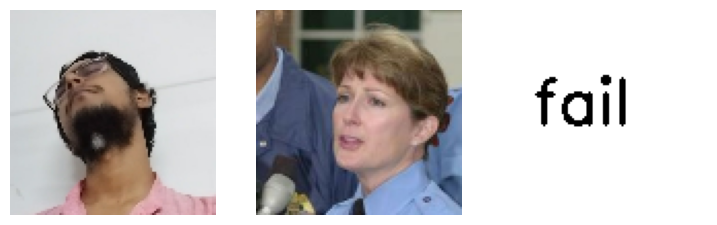

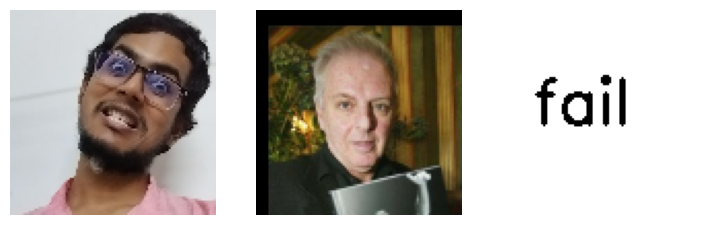

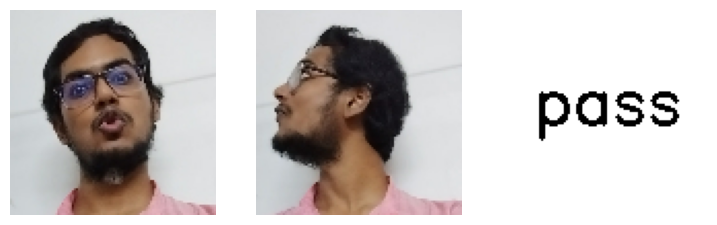

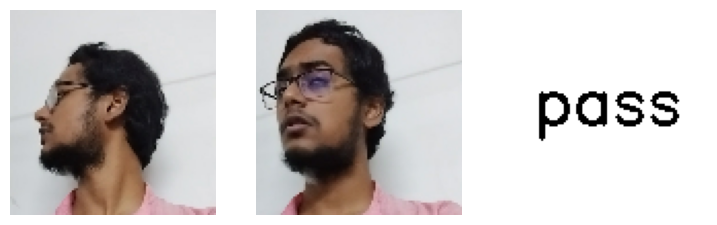

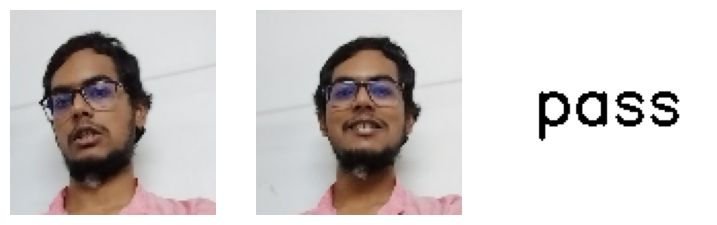

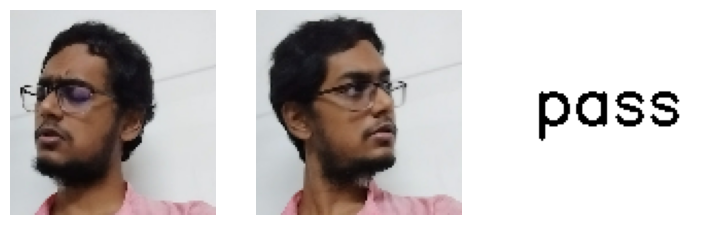

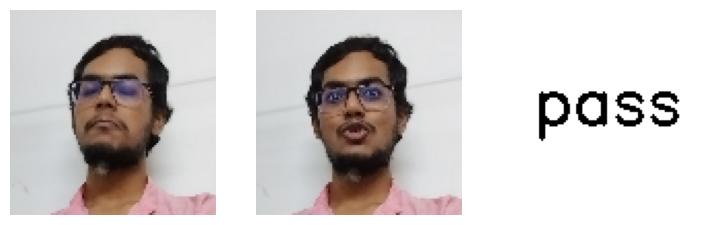

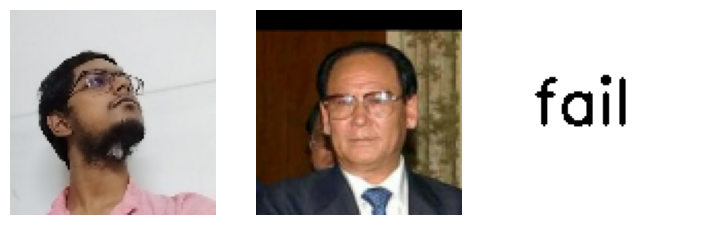

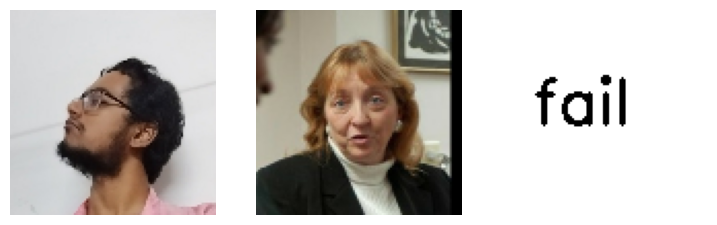

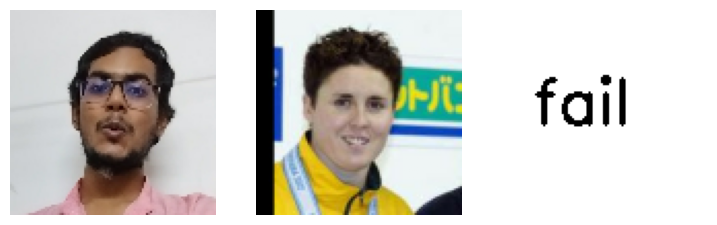

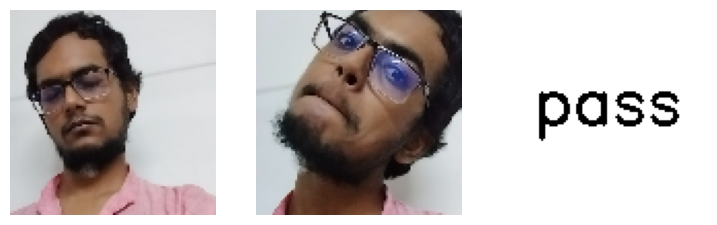

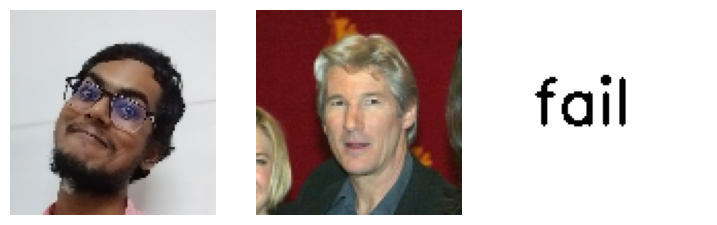

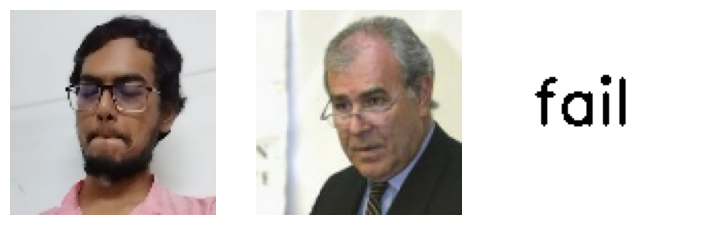

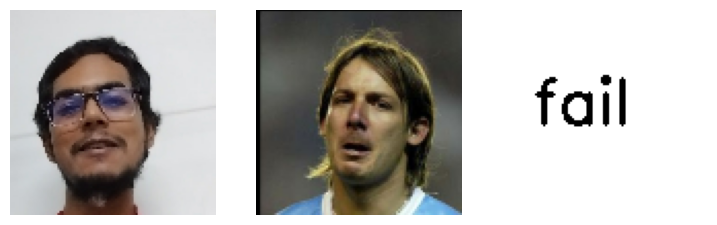

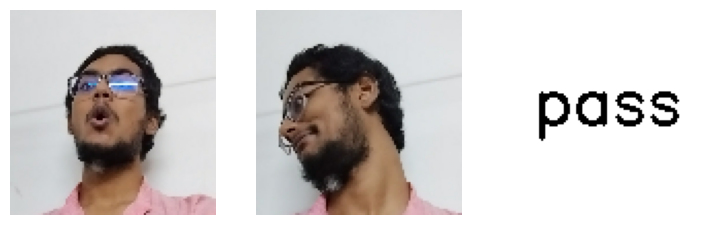

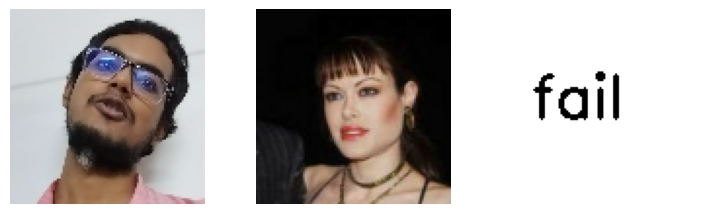

In [125]:
# Visualization of test results
# If the two images match => pass
# If they don't match => fail

test_batch=test_data.as_numpy_iterator().next()  # Take a test batch
test_input, test_val, y_true = test_batch
y_hat = siamese_model.predict([test_input, test_val])

for i in range(len(y_true)):
  fig=plt.figure(figsize=(3*3,3*len(y_true)))
  fig.add_subplot(i+1,3,1).imshow(test_input[i])
  plt.axis('off')
  fig.add_subplot(i+1,3,2).imshow(test_val[i])
  plt.axis('off')
  if(y_hat[i,0].round()==1):text_str='pass'
  else:text_str='fail'
  text=np.full((100,100,3),255,dtype='uint8')
  cv2.putText(text,text_str,(15,55),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),thickness=2)
  fig.add_subplot(i+1,3,3).imshow(text)
  plt.axis('off');